In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ast
import os
import sys
import pymc as pm
import pandas as pd

from pathlib import Path

lib_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'lib'))
print("Lib path:", lib_path)

# Append the absolute path to sys.path
sys.path.append(lib_path)

# Now, try importing onedmodel
from onedmodel import *

Lib path: /Users/guime/projects/SLTforSGD/code/lib


In [13]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

## Plot fraction of trajectories when escaping in 1D

In [86]:
# Initialise
nSGD = 10**3
nsamples = 10**3
shuffle = True
batch_size= 20
lr = 0.01
w0 = 1.8
seed_init = 1
seed_data = 1
nw0 = 2
d1 = 1
d2 = 2
wmax = nw0 * w0
frac_max = 10**-3
model = PolyModel(w0=w0, seed=seed_init, wmax=wmax, wmin=-wmax, d1=d1,d2=d2)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories(model)

/Users/guime/projects/SLTforSGD/code/lib/onedmodel.py:472: RuntimeWarning: divide by zero encountered in log
  log_frac = np.log(fraction)


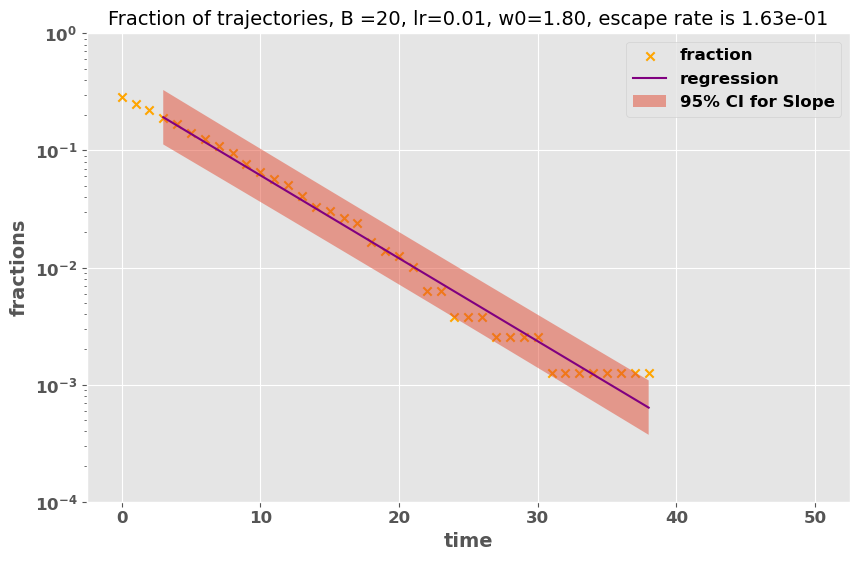

In [87]:
%matplotlib inline
trajectories = np.asarray(df['trajectory'].to_list())
clean_traj = trajectories[~np.isnan(trajectories).any(axis=1)]
fraction = regular_fraction(clean_traj, model)
escape_rate, error = compute_escape_rate(fraction, frac_max=frac_max, tmin=3,
                            batch_size=batch_size, lr=0.01, w0=w0)

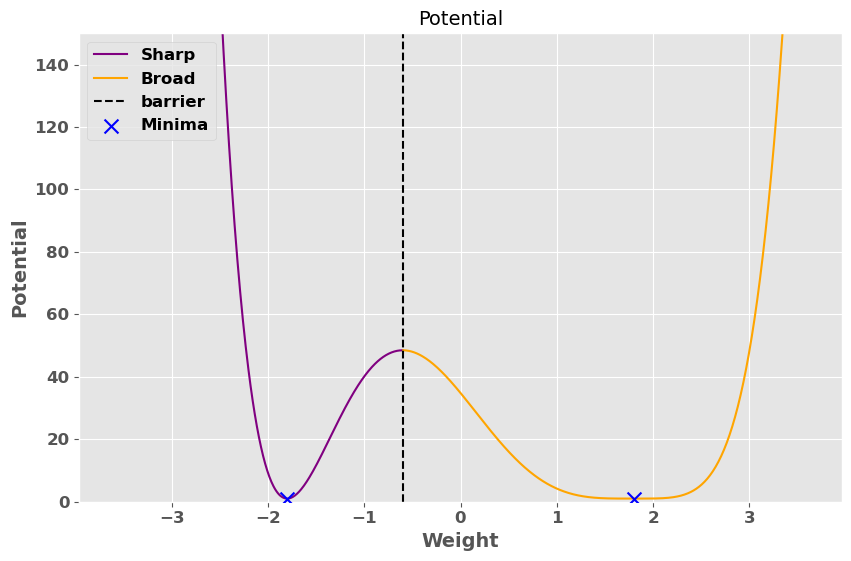

In [88]:
plot_potential(model, nsamp = 10**4, ymax = 150)

Text(0.5, 1.0, 'Distribution of SGD trajectories after 50.0 iterations')

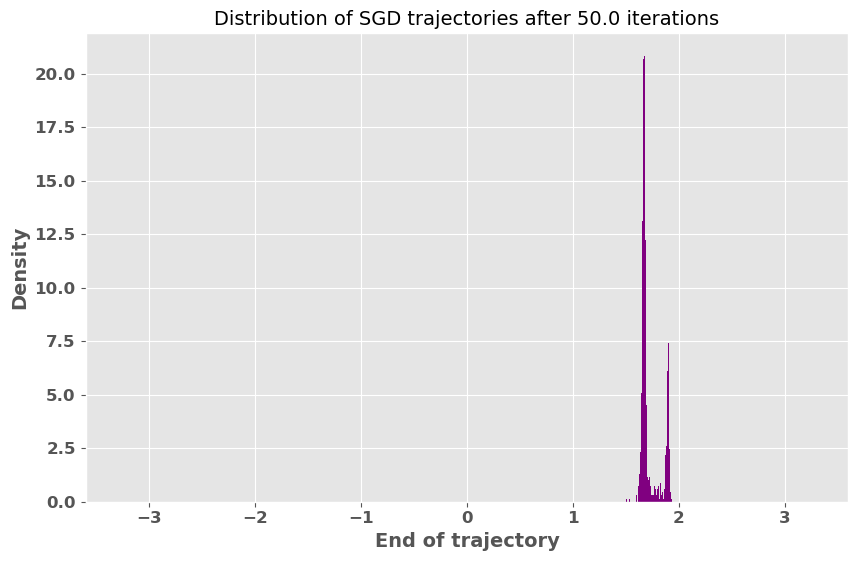

In [89]:
wf = []
for i in range(len(df)):
    wf.append(df["trajectory"][i][-1])
niterations = nSGD/batch_size
plt.hist(wf, bins=50, density=True, color="purple")
plt.xlabel("End of trajectory")
plt.ylabel("Density")
plt.xlim((-wmax, wmax))
plt.title(f"Distribution of SGD trajectories after {niterations} iterations")

## Plot 1D posterior

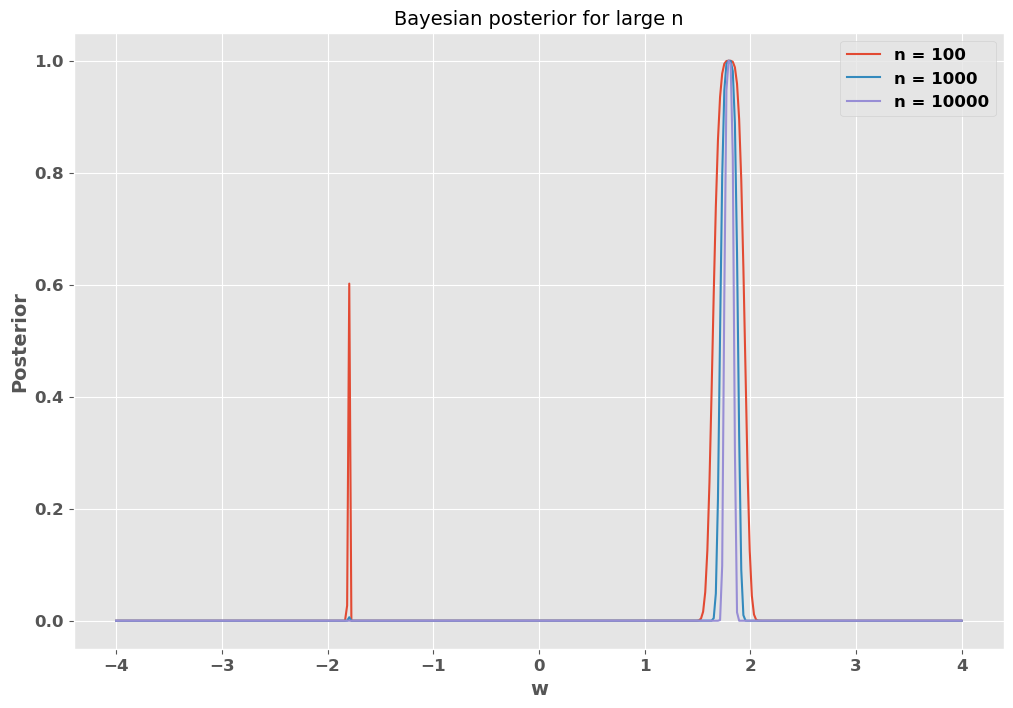

In [63]:
# Exact
n_values = [100, 1000, 10000]

w = np.linspace(-4, 4, 400)
K_w = (w - w0)**4 * (w + w0)**2
# Plotting the function for different values of n
plt.figure(figsize=(12, 8))

for n in n_values:
    l = np.exp(-n*K_w)
    plt.plot(w, l, label=f'n = {n}')
plt.title('Bayesian posterior for large n')
plt.xlabel('w')
plt.ylabel('Posterior')
plt.legend()
plt.grid(True)
plt.yscale("linear")  # Using a logarithmic scale for better visualization
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (6 chains in 1 job)
NUTS: [w]


Sampling 6 chains for 4_000 tune and 4_000 draw iterations (24_000 + 24_000 draws total) took 20 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


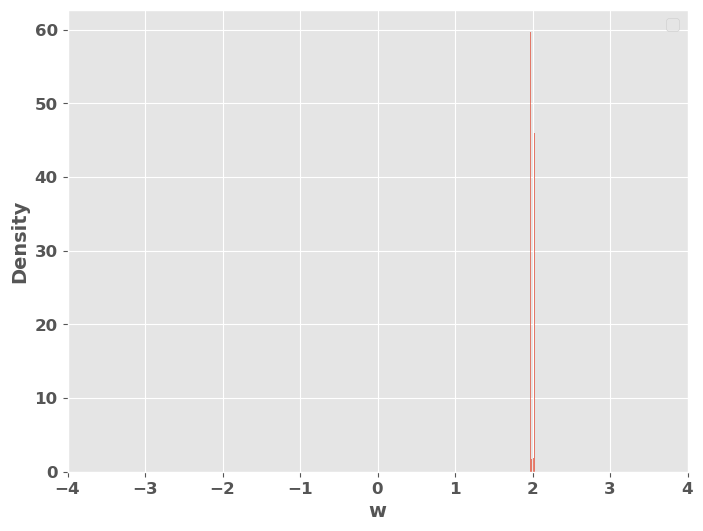

In [6]:
# Generate synthetic data
def generate_data(n_samples=1000):
    x = np.random.normal(0, 1, n_samples)
    y = np.random.normal(0, 1, n_samples)
    return x, y

# Set up the problem
n_samples = 20000
# Generate synthetic data
x, y = generate_data(n_samples=n_samples)

# Define the model using PyMC3
with pm.Model() as pmModel:
    # Prior distribution for w
    w = pm.Uniform('w', lower=-model.wmax, upper=model.wmax)
    
    # Likelihood function
    likelihood = pm.Normal('likelihood', mu=(w + model.w0)**model.d1 * (w - model.w0)**model.d2 * x, sigma=0.1, observed=y)
    
    # Perform MCMC sampling
    trace = pm.sample(4000, tune=4000, cores=1, chains=6, random_seed=42)

# Extract the sampled values of w

w_samples = trace.posterior['w'].values.flatten()

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(w_samples, bins=50, density=True, alpha=0.7)
#ax.axvline(model.w0, color='r', linestyle='--', label='Most singular')
ax.set_xlim((-wmax, wmax))
ax.set_xlabel('w')
ax.set_ylabel('Density')
ax.legend()
plt.show()

## Plot trajectories when escaping in 2D

In [80]:
# Initialise
nSGD = 10
nsamples = 10**6
shuffle = True
batch_size= 20
lr = 0.01
seed_init = 1
seed_data = 1
wxm = 0
wym = 10
d=1
wx_init = torch.tensor(0.0) 
wy_init = torch.tensor(-10.0)
model = PolyModel2D(seed=seed_init, wxm=wxm, wym=wym, wx_init=wx_init, wy_init = wy_init, d=d)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories2d(model)

50001


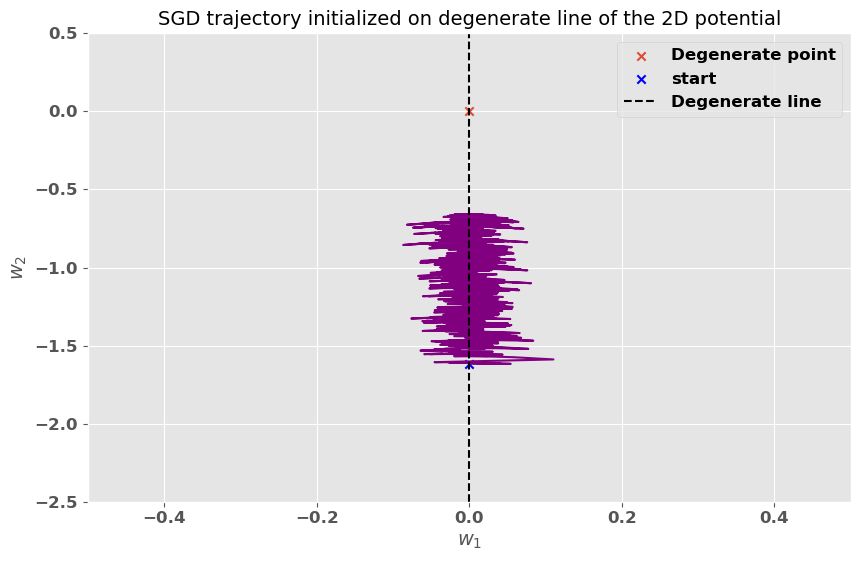

In [81]:
%matplotlib inline
wx = df["trajectory1"][0]
wy = df["trajectory2"][0]
print(len(wx))
fig, ax = plt.subplots()
plt.plot(wx,wy, color='purple')
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.xlim((-0.5, 0.5))
plt.ylim((-2.5, 0.5))
plt.grid(True)
plt.scatter(0,0,marker='x', label="Degenerate point")
plt.scatter(wx[0], wy[0], marker='x', label="start", color='blue')
plt.axvline(x=0, linestyle='--',label = "Degenerate line", color='k')
plt.title("SGD trajectory initialized on degenerate line of the 2D potential")
plt.legend()
plt.show()

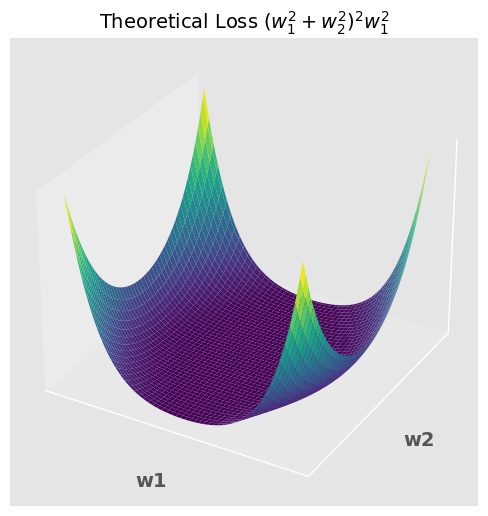

In [76]:
# 2D potential
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of points
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
wx, wy = np.meshgrid(w1, w2)

# Calculate the loss function values
k = (wx**2 + wy**2)**2 * wx**2

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(wx, wy, k, cmap='viridis')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title(r'Theoretical Loss $(w_1^2 + w_2^2)^2w_1^2$')

# Display the plot
plt.show()

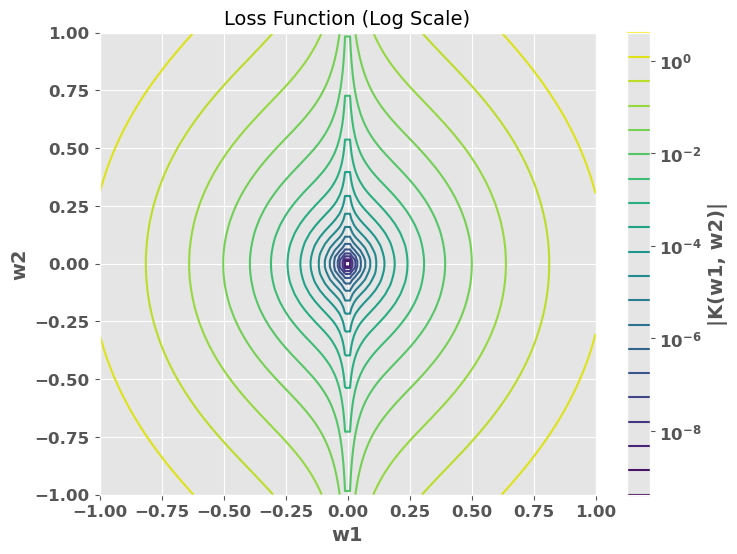

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Create a grid of points
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

# Calculate the loss function values
K = (W1**2 + W2**2)**2 * W1

# Create a contour plot with logarithmically spaced levels
fig, ax = plt.subplots(figsize=(8, 6))
min_val = np.min(np.abs(K))
max_val = np.max(np.abs(K))
levels = np.logspace(np.log10(min_val), np.log10(max_val), 20)
contour = ax.contour(W1, W2, np.abs(K), levels=levels, cmap='viridis', norm=LogNorm())
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_title('Loss Function (Log Scale)')

# Add a colorbar
fig.colorbar(contour, ax=ax, label='|K(w1, w2)|', ticks=plt.LogLocator(), format=plt.LogFormatterMathtext())

# Display the plot
plt.show()

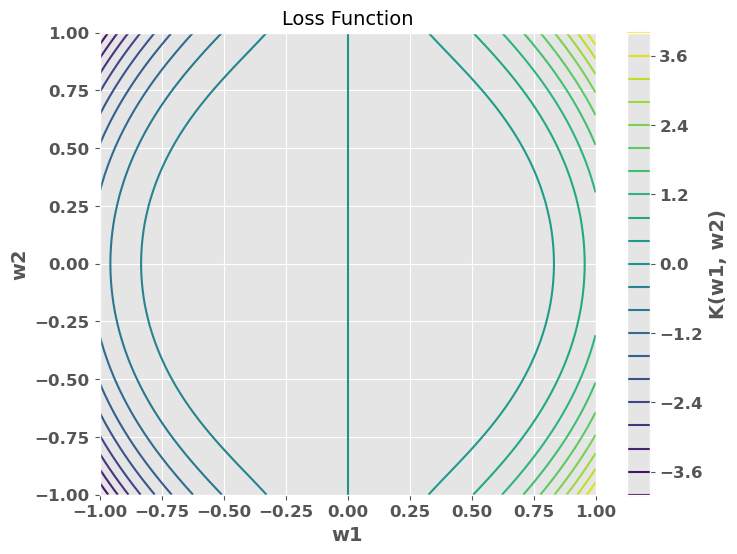

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of points
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

# Calculate the loss function values
K = (W1**2 + W2**2)**2 * W1

# Create a contour plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contour(W1, W2, K, levels=20, cmap='viridis')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_title('Loss Function')

# Add a colorbar
fig.colorbar(contour, ax=ax, label='K(w1, w2)')

# Display the plot
plt.show()

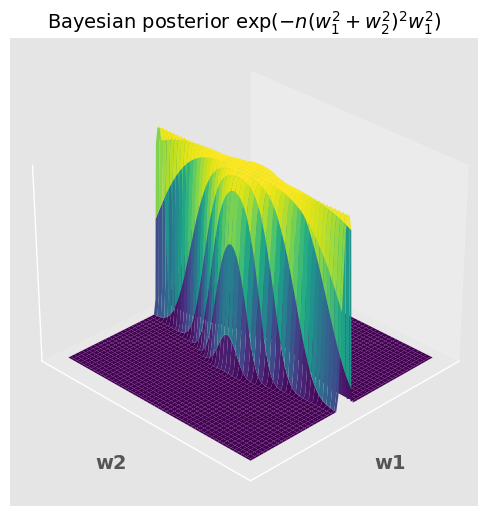

In [78]:
# 2D posterior
from mpl_toolkits.mplot3d import Axes3D

n = nsamples
# Create a grid of points
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
wx, wy = np.meshgrid(w1, w2)

# Calculate the loss function values
k = (wx**2 + wy**2)**2 * wx**4
post = np.exp(-n*k)
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(wx, wy, post, cmap='viridis')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title(r'Bayesian posterior $\exp(-n(w_1^2 + w_2^2)^2w_1^2)$')

# Display the plot
# Set the initial viewing angle
elev = 30  # Elevation angle in degrees
azim = 45  # Azimuth angle in degrees
ax.view_init(elev=elev, azim=azim)

# Display the plot
plt.show()

In [28]:
# Initialise
nSGD = 10*4
nsamples = 10**5
shuffle = True
batch_size= 20
lr = 0.01
seed_init = 1
seed_data = 1
wxm = 1
wym = 1
d=1
model = PolyModel2D(seed=seed_init, wxm=wxm, wym=wym, d=d)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories2d(model)

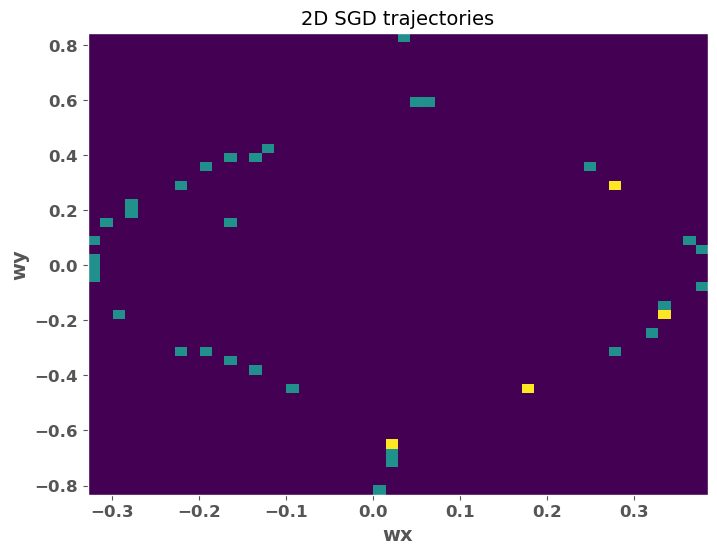

In [30]:
wx = df["trajectory1"].to_list()
wy = df["trajectory2"].to_list()
wx = np.array(wx)
wy = np.array(wy)

wx = wx[:,-1]
wy = wy[:,-1]

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
hist, xedges, yedges, _ = ax.hist2d(wx, wy, bins=50, density=True, cmap='viridis')
ax.set_xlabel('wx')
ax.set_ylabel('wy')
ax.set_title('2D SGD trajectories')
plt.show()



## Bayesian posterior 2D

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, w2]


Sampling 2 chains for 2_000 tune and 4_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


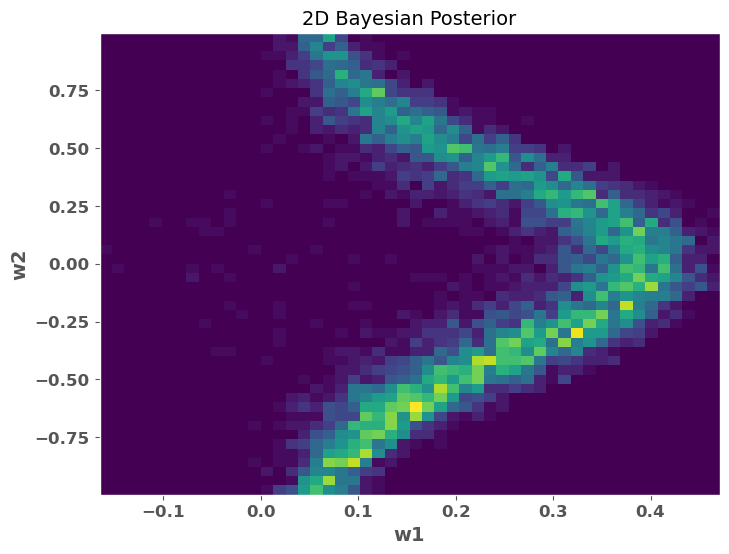

In [8]:
%matplotlib inline
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_data(n_samples=1000):
    x = np.random.normal(0, 1, n_samples)
    y = np.random.normal(0, 1, n_samples)
    return x, y


# Set up the problem
wxmax = 1  # Assuming the maximum value for w1 and w2
wymax = 1
n_samples = 3000
d=1
# Generate synthetic data
x, y = generate_data(n_samples=n_samples)

# Define the model using PyMC3
with pm.Model() as pmModel:
    # Prior distributions for w1 and w2
    w1 = pm.Uniform('w1', lower=-wxmax, upper=wxmax)
    w2 = pm.Uniform('w2', lower=-wymax, upper=wymax)
    
    # Likelihood function
    likelihood = pm.Normal('likelihood', mu=(w1**2 + w2**2) * w1**d * x, sigma=1, observed=y)
    
    # Perform MCMC sampling
    trace = pm.sample(4000, tune=2000, cores=1, chains=2, random_seed=42, target_accept=0.8)

# Extract the sampled values of w1 and w2
w1_samples = trace.posterior['w1'].values.flatten()
w2_samples = trace.posterior['w2'].values.flatten()

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
hist, xedges, yedges, _ = ax.hist2d(w1_samples, w2_samples, bins=50, density=True, cmap='viridis')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_title('2D Bayesian Posterior')
plt.show()

(50, 50)


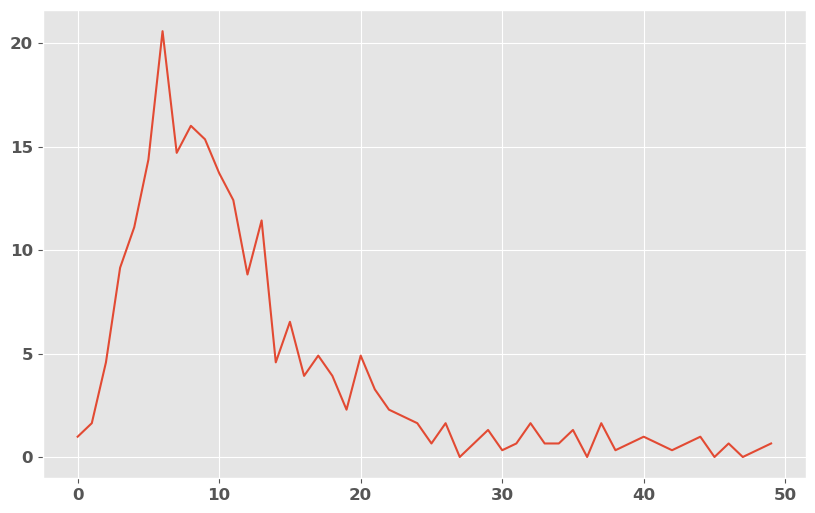

In [58]:
mid_hist = hist[:, 25]
print(hist.shape)
plt.plot(mid_hist)